In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sp
import scipy.stats as ss

# Proof of stake and decentrality

## Share of coins owned by each peer through simulation

Let $p$ be the number of peers and $N_x$ the number of coins of owned by peer $x\in\{1,\ldots, p\}$ at time $n=0$ and $N = \sum_x N_x$ the total number of coins.

We define the processes $(Y_n)_{n\geq0}$ and  $(Z_n)_{n\geq0}$ as the number and proportion of balls of each color at time $n\geq0$.

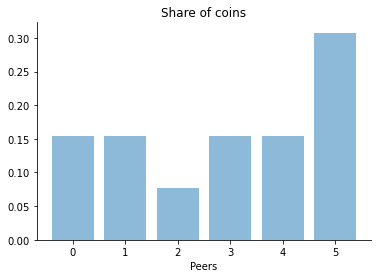

In [184]:
# Initialization of the process
p = 6
peers = np.arange(0,p,1)
N_x = np.random.randint(low = 1, high = 5, size = p)
N, Y_0 = sum(N_x), N_x
Z_0 = Y_0 / sum(Y_0)
plt.bar(peers, Z_0, width=0.8, alpha = 0.5)
plt.xticks(peers)
plt.xlabel('Peers')
plt.title('Share of coins')
sns.despine()

The process $(Z_n)$ is a martingale and is therefore stable on average. When $r=1$ then it converges toward a Dirichlet distribution of parameter $N_x,\text{ }x=1,\ldots, p$. The $i^{th}$ component of $Z_n = (Z_n^1,\ldots, Z_n^p)$ then converges toward a Beta distribution of parameter $(N_i, N - N_i)$. 

We sample $1,000$ realizations of $Z_{100}$

In [185]:
Z_100 = []
for l in range(1000):
    Y_n, Z_n = [Y_0], [Z_0]
    for k in range(100):
        # Vector of reward
        R = np.zeros(p)
        # Reward all equal to 0 except for that selected peer
        R[np.random.choice(peers, 1, p=Z_n[-1])[0]] = 1
        Y_n.append(Y_n[-1] + R)
        Z_n.append(Y_n[-1] / sum(Y_n[-1]))
    Z_100.append(Z_n[-1])

We then draw the histograms for each component of $Z_n$ to compare them with the pdf of the beta distribution.

[-0.00262491 -0.0029258  -0.00106467  0.0019857   0.00349898  0.0011307 ]


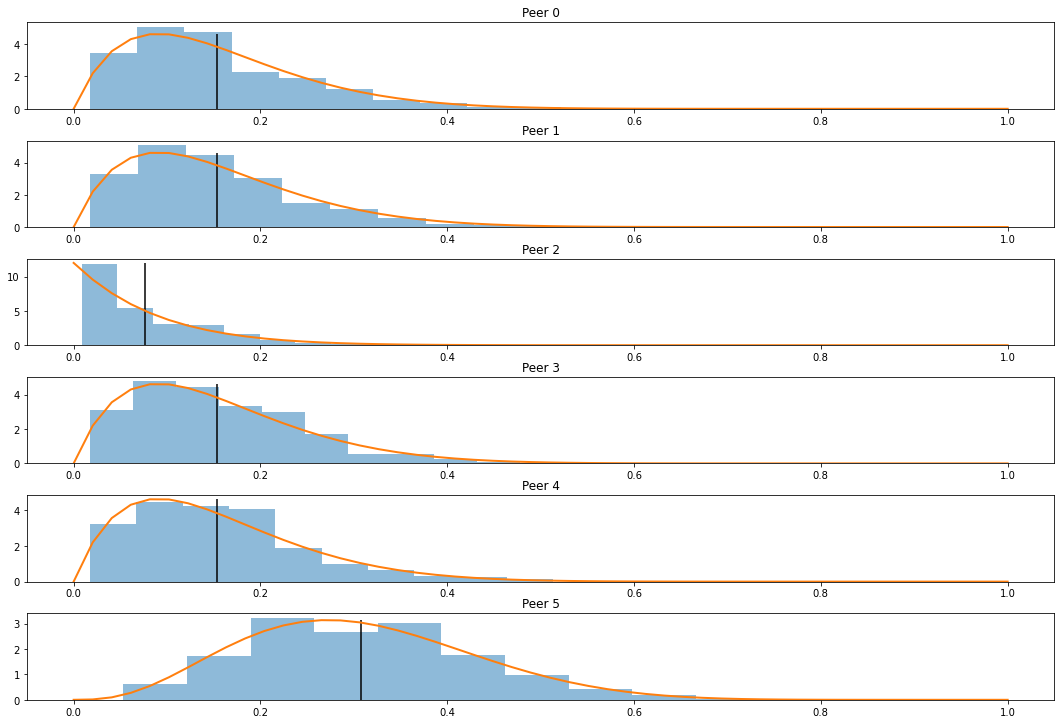

In [186]:
print(np.mean(Z_100, 0)-Z_0)
# np.mean(Z_100, 0)
fig, ax = plt.subplots(len(peers), 1, figsize=(15,10))
fig.tight_layout()
for peer in peers:
    ax[peer].hist(np.matrix(Z_100)[:,peer], density=True, alpha = 0.5)
    x = np.linspace(0,1)
    y = ss.beta(Y_0[peer],sum(Y_0) - Y_0[peer]).pdf(x)
    ax[peer].plot(x, y , lw=2)
    ax[peer].vlines(Z_0[peer], ymin = 0, ymax = max(y), color = "black")
    ax[peer].title.set_text("Peer " + str(peer))

## Measuring decentrality

We can measure decentrality by calculating the expected Shannon entropy of the resulting distribution of coins among the peers. The best situation corresponds to a uniform distribution among the peers and an entropy of 

$$
\ln(p)
$$

The vector $Z_n$ converges toward a Dirichlet distribution with parameter $N_x\text{, }x = 1,\ldots, p$  whose entropy is given by 

$$
-\sum_x\frac{N}{N_x}\left[\psi(N_x+1)-\psi(N+1)\right]
$$

where $\psi$ is the digamma function. [scipy.special.digamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.digamma.html)


On average and upon stationarity, the entropy of the network is 1.527787816758405 to be compared with 1.791759469228055


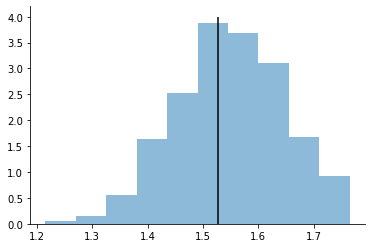

In [181]:
print("On average and upon stationarity, the entropy of the network is "
      + str(-sum(N_x/N*(sp.psi(N_x + 1) - sp.psi(N + 1)))) +
      " to be compared with "+
      str( np.log(p))
         )

emp_entropy = [-sum(Z_100[k] * np.log(Z_100[k])) for k in range(len(Z_100))]
plt.hist(emp_entropy, alpha = 0.5, density = True)
plt.vlines(-sum(N_x/N*(sp.psi(N_x + 1) - sp.psi(N + 1))), ymin = 0, ymax = 4, color = "black")
sns.despine()

# Blockchain queue

Blockchain efficiency is characterized by the 
- throughput (how many transactions are confirmed per time unit) 
- latency (the average confirmation time of a transaction). 

These quantities are studied within the frame of a queueing model. 

- The pending transactions arrive at a Poisson rate $\lambda$ to form a queue, 
- a fixed number $b$ (the first which entered the queue) will be processed in a block. 
- The block generation time has distribution $G$ on $\mathbb{R}_+$. 

The result is a $M/G^b/1$ queue. 

We are going to simulate trajectories of this process to study the average confirmation time and the number of pending transaction in the queue at stationarity. 

Let us assume that $G$ is exponential with mean $1/\mu$, which corresponds to the empirical data on the block arrival time in the bitcoin blockchain.

Denote by $(S_i)$ the transaction arrival time and $(T_i)$ the blockarrival times.

We denote by $N_t$ the number of transaction and $M_t$ the number of block up to time $t>0$. Both of the processes are Poisson process with respective intensity $\lambda$ and $\mu$.

In [220]:
# Parameters of the transaction arrival, the block size and the service time
μ, λ, b = 3, 8, 3
print("stationarity holds? "+ str(λ < b * μ) )
# We set a time horizon, the higher the better to reach stationarity
t = 10000
# Number of transactions issued and number of blocks generated
N_t, M_t = np.random.poisson(λ * t), np.random.poisson(μ * t)
# Transaction and block arrival times
S, T = np.sort(np.random.uniform(low = 0, high = t, size = N_t)), np.sort(np.random.uniform(low = 0, high = t, size = M_t))
T = np.insert(T, 0, 0)

stationarity holds? True


In [221]:
queue = np.array([])
server = []
conf_time = []
for k in range(len(T)-1):    
    queue = np.append(queue, S[np.logical_and(S>T[k], S < T[k+1])])
    if len(queue) > b:
        conf_time.append(np.sum(T[k+1] - queue[:b]))
        server.append(b)
        queue = queue[b:]
    else:
        if len(queue) > 0:
            conf_time.append(np.sum(T[k+1] - queue))
            server.append(len(queue))
            queue = np.array([])
        else:
            server.append(0)


In [222]:
print(np.sum(conf_time) / sum(S < T[-1]), np.mean(server))

1.966338054529044 2.671020980890017


Theoreticaly the mean confirmation time is given by 

$$
\frac{p}{(1-p)\lambda}
$$
where $p=1/z^\ast$ and $z^\ast$ is the only root to 
$$
-\frac{\lambda}{\mu}z^{b+1}+z^b\left(\frac{\lambda}{\mu}+1\right) - 1,
$$
such that $|z^\ast$|>1.

In [223]:
import scipy as sc
def f(x):
    return(- λ / μ *x**(b+1) + x**b * (λ / μ + 1) - 1 )

sol = sc.optimize.root_scalar(f, bracket=[1.00001, 100000], method='brentq')
p = 1/sol.root
geom_pmf = np.array([p**k * (1-p) for k in np.arange(0,b+1)])
latency, throughput = p/(1-p)/λ, sum(np.arange(0,b+1) * geom_pmf) + p**(b+1)*b

print(latency, throughput)

2.039630641416744 2.666666666666134


What is the server occupancy?

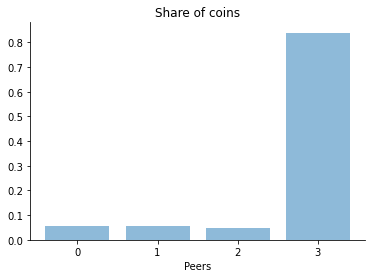

In [224]:
# sum(server == 0)/len(server)
plt.bar(np.arange(0, b+1,1), np.array([np.mean(np.array(server)==k) for k in range(b+1)]), alpha = 0.5)
plt.xticks(np.arange(0, b+1,1))
plt.xlabel('Peers')
plt.title('Share of coins')
sns.despine()